# I.Import library

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [5]:
#you should use google colab to run this code, if you run in local machine please remove "!" to run this code
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# II.Mount drive

In [2]:
#if you use local machine, skip this cell code

# from google.colab import drive
# drive.mount("/content/drive")

Mounted at /content/drive


# III.Load and preprocessing data

**1.Load data**

In [3]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
DIRECTORY = r"/content/drive/MyDrive/Home/Mini_Project/3_Face_Mask_Detection/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [4]:
print("[INFO] loading image.......")
data = []
labels = []
for category in CATEGORIES:
  path = os.path.join(DIRECTORY, category)
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size = (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(category)

[INFO] loading image.......


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


**2.Encoded data**

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
data = np.array(data, dtype = "float32")
labels = np.array(labels)

**3.Split train and test set**

In [8]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size = 0.2, stratify = labels, random_state = 42)

In [9]:
trainX.shape

(3076, 224, 224, 3)

**4.Augument data**

In [10]:
aug = ImageDataGenerator(rotation_range = 20,
                         zoom_range = 0.15,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         shear_range = 0.15,
                         horizontal_flip = True,
                         fill_mode = "nearest")

# IV.Build model

**1.Build model**

In [11]:
baseModel = MobileNetV2(weights = "imagenet", include_top = False,
                        input_tensor = Input(shape = (224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size = (7, 7))(headModel)
headModel = Flatten(name = "flatten")(headModel)
headModel = Dense(128, activation = "relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation = "softmax")(headModel)
model = Model(inputs = baseModel.input, outputs = headModel)

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
for layer in baseModel.layers:
  layer.trainable = False

In [13]:
print("[INFO] compiling model......")
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=10000,
    decay_rate=INIT_LR / EPOCHS)
opt = Adam(learning_rate = lr_schedule)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])
model.summary()

[INFO] compiling model......
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                

**2.Training model**

In [14]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Home/Mini_Project/3_Face_Mask_Detection/best_model_facemask.h5', 
                                                         monitor='val_accuracy', 
                                                         save_best_only=True, 
                                                         save_weights_only=False, 
                                                         mode='max', 
                                                         verbose=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Home/Mini_Project/3_Face_Mask_Detection/logs', 
                                                       histogram_freq=1, 
                                                       write_graph=True, 
                                                       write_images=True)

In [15]:
history = model.fit(aug.flow(trainX, trainY, batch_size = BS),
                    steps_per_epoch = len(trainX) // BS,
                    validation_data = (testX, testY),
                    validation_steps = len(testX) // BS,
                    epochs = EPOCHS,
                    callbacks=[checkpoint_callback, tensorboard_callback])

Epoch 1/20
96/96 [==============================] - ETA: 0s - loss: 0.4117 - accuracy: 0.8308
Epoch 1: val_accuracy improved from -inf to 0.98052, saving model to /content/drive/MyDrive/Home/Mini_Project/3_Face_Mask_Detection/best_model_facemask.h5
96/96 [==============================] - 55s 447ms/step - loss: 0.4117 - accuracy: 0.8308 - val_loss: 0.1462 - val_accuracy: 0.9805
Epoch 2/20
96/96 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9602
Epoch 2: val_accuracy did not improve from 0.98052
96/96 [==============================] - 39s 408ms/step - loss: 0.1510 - accuracy: 0.9602 - val_loss: 0.0898 - val_accuracy: 0.9779
Epoch 3/20
96/96 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9747
Epoch 3: val_accuracy improved from 0.98052 to 0.98182, saving model to /content/drive/MyDrive/Home/Mini_Project/3_Face_Mask_Detection/best_model_facemask.h5
96/96 [==============================] - 40s 415ms/step - loss: 0.1039 - accuracy: 0.9747 

In [ ]:
#model.save("/content/drive/MyDrive/Test_Project/Face_Mask_Detection/mask_detector.model", save_format="h5")

# V.Evaluation model

**1.Evaluate accuracy, precision, recall, f1-score**

In [16]:
print("[INFO] evaluating network.....")
pred = model.predict(testX, batch_size = BS)

[INFO] evaluating network.....
25/25 [==============================] - 2s 61ms/step


In [17]:
y_pred = np.argmax(pred, axis = 1)
print(classification_report(testY.argmax(axis = 1), y_pred, target_names = lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       385
without_mask       0.99      0.98      0.99       385

    accuracy                           0.99       770
   macro avg       0.99      0.99      0.99       770
weighted avg       0.99      0.99      0.99       770



**2.Load tensorboard**

In [26]:
# %load_ext tensorboard
# %tensorboard --logdir=/content/drive/MyDrive/Home/Mini_Project/3_Face_Mask_Detection/logs

In [25]:
#if you run code above successfully, do not need run this code because it is same

# %reload_ext tensorboard
# %tensorboard --logdir=/content/drive/MyDrive/Home/Mini_Project/3_Face_Mask_Detection/logs --port=6007

**3.Plot loss and accuracy**

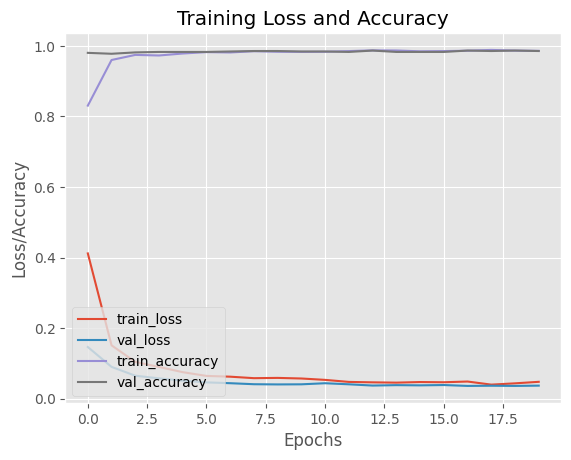

In [23]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "lower left")


# VI.Unmount drive

In [24]:
#if you use local machine, skip this cell code

# from google.colab import drive
# drive.flush_and_unmount()